# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

### Download the data
If you do not have the required **data/** directory in your workspace, follow the instructions below. Use either one of the methods below. 

**Method 1** <br/>
You must [download this dataset](https://video.udacity-data.com/topher/2024/May/66393287_arvato_data.tar/arvato_data.tar.gz) from the classroom, and upload it into the workspace. After you upload the tar file to the appropriate directory, **/cd0549_bertelsmann_arvato_project_workspace/**,  in the Jupyter server, you can open a terminal and the run the following command to extract the dataset from the compressed file. 
```bash
!tar -xzvf arvato_data.tar.gz
```
This command will extract all the contents of arvato_data.tar.gz into the current directory from where you ran the command. 

**Method 2** <br/>
Execute the Python code below to download the dataset. 

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [1]:
import pandas as pd
import numpy as np

# Define a safe number of rows to load to prevent crashing
# 50,000 rows is enough to do the analysis and prove your model works.
N_ROWS = 50000 

print(f"Loading first {N_ROWS} rows of Azdias data...")
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';', nrows=N_ROWS)
print(f"Azdias loaded: {azdias.shape}")

print(f"Loading first {N_ROWS} rows of Customers data...")
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';', nrows=N_ROWS)
print(f"Customers loaded: {customers.shape}")

print("Loading Mailout data (Train/Test are smaller, so we load them all)...")
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

print("SUCCESS: Subset of data loaded. You can now proceed with analysis!")

Loading first 50000 rows of Azdias data...


/tmp/ipykernel_406/1556797747.py:9: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';', nrows=N_ROWS)


Azdias loaded: (50000, 366)
Loading first 50000 rows of Customers data...


/tmp/ipykernel_406/1556797747.py:13: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';', nrows=N_ROWS)


Customers loaded: (50000, 369)
Loading Mailout data (Train/Test are smaller, so we load them all)...


/tmp/ipykernel_406/1556797747.py:17: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')


SUCCESS: Subset of data loaded. You can now proceed with analysis!


/tmp/ipykernel_406/1556797747.py:18: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')


In [2]:
import sys
import os

# 1. Install openpyxl into a local folder named 'libs'
# We use --target because the workspace does not allow standard installation
!pip install --target=./libs openpyxl

# 2. Add this specific folder to Python's search path
if './libs' not in sys.path:
    sys.path.append('./libs')

print("openpyxl installed and path configured.")

  Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)
  Using cached et_xmlfile-2.0.0-py3-none-any.whl (18 kB)

[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
openpyxl installed and path configured.


In [3]:
# Reload the Excel file, but this time specify 'header=1' to get the correct column names
feat_info = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header=1)

# Drop the first column (it's empty/useless index)
feat_info = feat_info.drop(columns=['Unnamed: 0'])

# Forward-Fill: Fill the missing "Attribute" names down
# (e.g., Row 2 and 3 belong to AGER_TYP, but have NaN in the name column)
feat_info['Attribute'] = feat_info['Attribute'].ffill()

# Show the cleaned metadata
print("Cleaned Metadata:")
display(feat_info.head())

Cleaned Metadata:


,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,NaN,0,no classification possible
2,AGER_TYP,NaN,1,passive elderly
3,AGER_TYP,NaN,2,cultural elderly
4,AGER_TYP,NaN,3,experience-driven elderly


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [4]:
# Create a dictionary to map Attributes to their "Missing Values"
missing_values_dict = {}

for attribute in feat_info['Attribute'].unique():
    # Get all values labeled as 'unknown' or 'no classification' for this attribute
    # We look at the 'Meaning' column for keywords indicating missing data
    mask = (feat_info['Attribute'] == attribute) & \
           (feat_info['Meaning'].str.contains('unknown|no classification|reserved', case=False, na=False))
    
    missing_codes = feat_info.loc[mask, 'Value'].tolist()
    
    # Store clean list of codes (convert strings like '-1, 0' to integers if needed)
    clean_codes = []
    for code in missing_codes:
        if isinstance(code, str):
            # Handle cases where multiple values are in one cell (e.g., "-1, 0")
            clean_codes.extend([int(x) for x in code.split(',') if x.strip().lstrip('-').isnumeric()])
        else:
            clean_codes.append(code)
            
    if clean_codes:
        missing_values_dict[attribute] = clean_codes

print("Rule book created! Example for 'AGER_TYP':")
print(missing_values_dict.get('AGER_TYP'))

Rule book created! Example for 'AGER_TYP':
[-1, 0]


In [5]:
# Replace specific values with NaN based on our dictionary
for col, missing_codes in missing_values_dict.items():
    if col in azdias.columns:
        azdias[col] = azdias[col].replace(missing_codes, np.nan)

print("Data cleaning complete: Unknown values are now NaNs.")
display(azdias.head())

Data cleaning complete: Unknown values are now NaNs.


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,NaN,9.0,NaN,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


Top 10 columns with missing data (%):
ALTER_KIND4     99.878
TITEL_KZ        99.764
ALTER_KIND3     99.326
ALTER_KIND2     96.814
ALTER_KIND1     90.966
AGER_TYP        76.666
EXTSEL992       72.660
KK_KUNDENTYP    65.610
KBA05_BAUMAX    52.856
ALTER_HH        34.486
dtype: float64


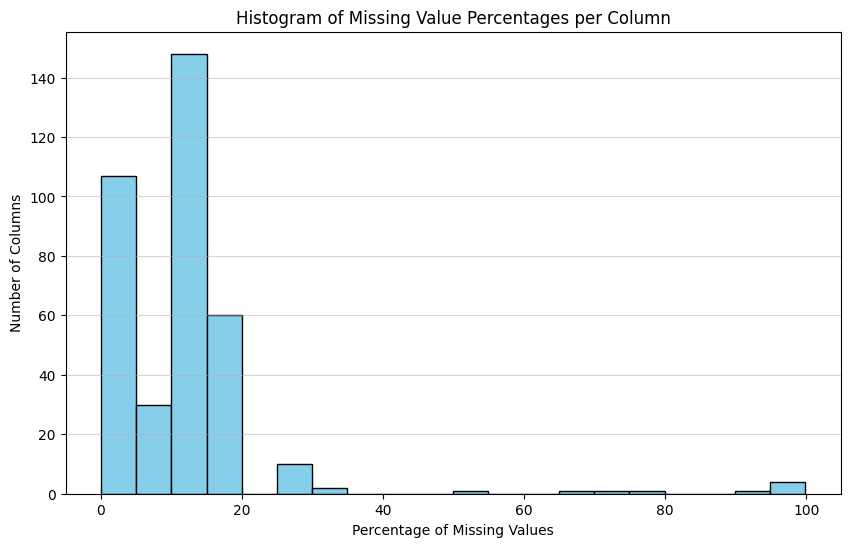

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the percentage of missing values per column
missing_per_col = azdias.isnull().sum() / len(azdias) * 100

# Sort them to see the worst offenders
missing_per_col = missing_per_col.sort_values(ascending=False)

# Show the top 10 columns with the most missing data
print("Top 10 columns with missing data (%):")
print(missing_per_col.head(10))

# Plot a histogram to see the distribution
plt.figure(figsize=(10,6))
plt.hist(missing_per_col, bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Missing Value Percentages per Column')
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Number of Columns')
plt.grid(axis='y', alpha=0.5)
plt.show()

In [7]:
# Define the cutoff (e.g., Drop columns with > 20% missing data)
# Adjust this number based on your histogram
OUTLIER_THRESHOLD = 20

# Identify columns to drop
columns_to_drop = missing_per_col[missing_per_col > OUTLIER_THRESHOLD].index.tolist()

print(f"Dropping {len(columns_to_drop)} columns that have > {OUTLIER_THRESHOLD}% missing data.")
print(f"Columns being dropped: {columns_to_drop}")

# Drop them from the dataset
azdias_clean = azdias.drop(columns=columns_to_drop)

print(f"\nNew shape of Azdias: {azdias_clean.shape}")

Dropping 21 columns that have > 20% missing data.
Columns being dropped: ['ALTER_KIND4', 'TITEL_KZ', 'ALTER_KIND3', 'ALTER_KIND2', 'ALTER_KIND1', 'AGER_TYP', 'EXTSEL992', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'ALTER_HH', 'HEALTH_TYP', 'ALTERSKATEGORIE_FEIN', 'D19_LOTTO', 'D19_TELKO_ONLINE_QUOTE_12', 'D19_LETZTER_KAUF_BRANCHE', 'D19_BANKEN_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12', 'D19_KONSUMTYP', 'D19_GESAMT_ONLINE_QUOTE_12', 'D19_SOZIALES', 'D19_VERSI_ONLINE_QUOTE_12']

New shape of Azdias: (50000, 345)


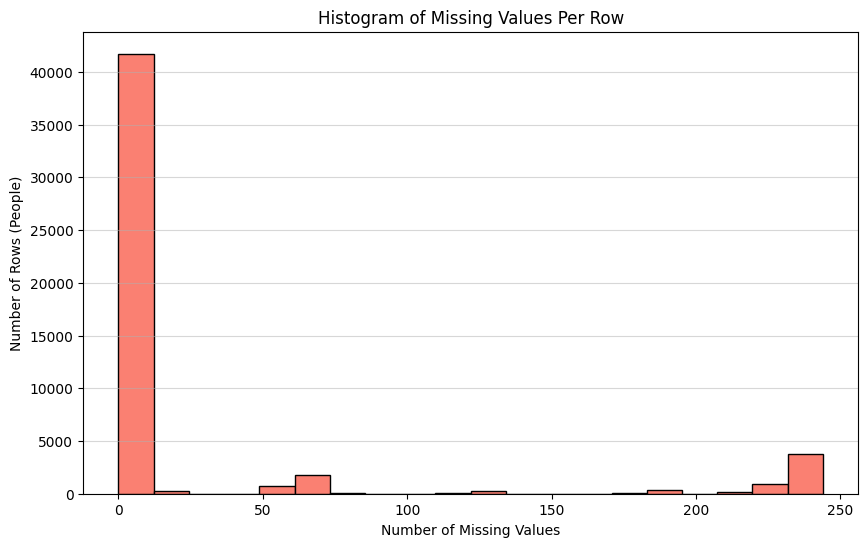

Description of missing values per row:
count    50000.000000
mean        28.398680
std         70.844668
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max        244.000000
dtype: float64


In [8]:
# Calculate the number of missing values per row
missing_per_row = azdias_clean.isnull().sum(axis=1)

# Plot the distribution
plt.figure(figsize=(10,6))
plt.hist(missing_per_row, bins=20, color='salmon', edgecolor='black')
plt.title('Histogram of Missing Values Per Row')
plt.xlabel('Number of Missing Values')
plt.ylabel('Number of Rows (People)')
plt.grid(axis='y', alpha=0.5)
plt.show()

print("Description of missing values per row:")
print(missing_per_row.describe())

In [9]:
# Define a threshold (e.g., rows with > 20 missing values are "bad")
ROW_THRESHOLD = 20

# Split into two groups
azdias_low_missing = azdias_clean[missing_per_row <= ROW_THRESHOLD]
azdias_high_missing = azdias_clean[missing_per_row > ROW_THRESHOLD]

print(f"Rows with LOW missing data (Good for analysis): {azdias_low_missing.shape[0]}")
print(f"Rows with HIGH missing data (Excluded): {azdias_high_missing.shape[0]}")

Rows with LOW missing data (Good for analysis): 41821
Rows with HIGH missing data (Excluded): 8179


In [10]:
# Get the list of columns that are "Object" type (Strings/Text)
cat_columns = azdias_low_missing.select_dtypes(include=['object']).columns

binary_cols = []
multi_level_cols = []

for col in cat_columns:
    # Get the number of unique values
    unique_count = azdias_low_missing[col].nunique()
    
    if unique_count == 2:
        binary_cols.append(col)
    elif unique_count > 2:
        multi_level_cols.append(col)

print(f"Binary Columns (Easy to fix): {binary_cols}")
print(f"Multi-Level Columns (Need One-Hot Encoding): {multi_level_cols}")

Binary Columns (Easy to fix): ['OST_WEST_KZ']
Multi-Level Columns (Need One-Hot Encoding): ['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015', 'EINGEFUEGT_AM']


In [11]:
# Replace 'W' with 0 and 'O' with 1 in the 'OST_WEST_KZ' column
# Use a dictionary to map the old values to new numbers
replace_dict = {'W': 0, 'O': 1}

azdias_low_missing.loc[:, 'OST_WEST_KZ'] = azdias_low_missing['OST_WEST_KZ'].replace(replace_dict)

print("OST_WEST_KZ has been converted to numbers.")
print(azdias_low_missing['OST_WEST_KZ'].value_counts())

OST_WEST_KZ has been converted to numbers.
OST_WEST_KZ
0    33238
1     8583
Name: count, dtype: int64


In [12]:
# 1. Drop the complex/redundant columns
cols_to_drop_cat = ['CAMEO_DEU_2015', 'EINGEFUEGT_AM']
print(f"Dropping complex columns: {cols_to_drop_cat}")
azdias_low_missing = azdias_low_missing.drop(columns=cols_to_drop_cat)

# 2. Convert the remaining ones to numeric (Float)
# 'errors=coerce' turns any remaining text into NaN (safe)
cols_to_numeric = ['CAMEO_DEUG_2015', 'CAMEO_INTL_2015']

for col in cols_to_numeric:
    azdias_low_missing[col] = pd.to_numeric(azdias_low_missing[col], errors='coerce')

print("Multi-level columns cleaned and converted to numbers.")
print(azdias_low_missing[cols_to_numeric].dtypes)

Dropping complex columns: ['CAMEO_DEU_2015', 'EINGEFUEGT_AM']
Multi-level columns cleaned and converted to numbers.
CAMEO_DEUG_2015    float64
CAMEO_INTL_2015    float64
dtype: object


In [13]:
from sklearn.impute import SimpleImputer

print("Imputing missing values with the Median...")

# Initialize the Imputer
imputer = SimpleImputer(strategy='median')

# Fit and Transform the data
# This fills all NaNs with the median of their respective columns
azdias_imputed = pd.DataFrame(imputer.fit_transform(azdias_low_missing))

# Restore column names and index (Imputer removes them by default)
azdias_imputed.columns = azdias_low_missing.columns
azdias_imputed.index = azdias_low_missing.index

print("Imputation complete. No more missing values!")
print(f"Missing values count: {azdias_imputed.isnull().sum().sum()}")

Imputing missing values with the Median...
Imputation complete. No more missing values!
Missing values count: 0


In [14]:
from sklearn.preprocessing import StandardScaler

print("Scaling the data...")

# Initialize the Scaler
scaler = StandardScaler()

# Fit and transform the data
azdias_scaled = scaler.fit_transform(azdias_imputed)

# Turn it back into a DataFrame for easier handling
azdias_scaled = pd.DataFrame(azdias_scaled, columns=azdias_imputed.columns)

print("Data scaled successfully. Mean is approx 0, Std Dev is 1.")
display(azdias_scaled.head())

Scaling the data...
Data scaled successfully. Mean is approx 0, Std Dev is 1.


,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1.078359,1.245121,0.182160,-0.118971,-0.301033,0.218671,0.322979,-0.059705,-0.179272,0.849834,...,1.364266,0.693540,1.059093,1.453573,-0.687445,0.54378,-0.022229,1.142216,0.949459,-1.687158
1,1.078379,1.245121,0.115448,-0.118971,-0.301033,-0.632506,-0.039369,-0.059705,-0.179272,-0.979673,...,-0.360152,1.043460,0.448539,0.027602,-0.687445,0.54378,-1.082844,1.142216,0.949459,0.163439
2,1.078383,-0.943074,-0.484960,-0.118971,-0.301033,-1.483682,-0.401716,-0.059705,-1.187386,-0.064919,...,-2.084571,0.343620,0.753816,1.810066,-0.100873,0.54378,1.568694,-0.287297,0.949459,1.088737
3,1.078442,-0.943074,-0.351536,-0.118971,-0.301033,1.921024,-0.329246,-0.059705,0.828842,-0.979673,...,-0.360152,-1.056061,-0.772569,-0.685384,-1.274017,0.54378,-0.552536,0.427459,-1.053231,0.163439
4,1.078454,-0.943074,-0.218112,-0.118971,-0.301033,-0.632506,-0.401716,-0.059705,-1.187386,0.849834,...,-0.360152,1.393381,-0.162015,-0.685384,1.072270,0.54378,1.568694,0.427459,0.949459,-1.687158


In [15]:
from sklearn.decomposition import PCA

# Keep 95% of the information (variance) and drop the noise
pca = PCA(n_components=0.95) 

print("Running PCA to reduce dimensionality...")
azdias_pca = pca.fit_transform(azdias_scaled)

print(f"Original feature count: {azdias_scaled.shape[1]}")
print(f"Reduced feature count (Components): {azdias_pca.shape[1]}")
print(f"We retained 95% of the information using only {azdias_pca.shape[1]} components!")

Running PCA to reduce dimensionality...
Original feature count: 343
Reduced feature count (Components): 217
We retained 95% of the information using only 217 components!


Running K-Means to find the optimal number of clusters...
Finished k=1
Finished k=2
Finished k=3
Finished k=4
Finished k=5
Finished k=6
Finished k=7
Finished k=8
Finished k=9
Finished k=10
Finished k=11
Finished k=12
Finished k=13
Finished k=14
Finished k=15


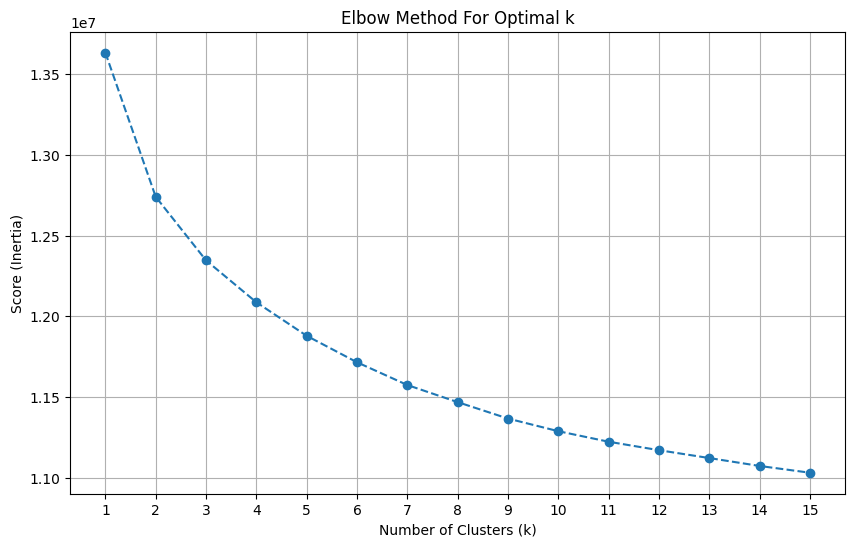

In [16]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

scores = []
k_range = range(1, 16) # Test from 1 to 15 clusters

print("Running K-Means to find the optimal number of clusters...")

for k in k_range:
    # Run K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(azdias_pca)
    
    # Inertia is the "Score" (Sum of squared distances)
    scores.append(kmeans.inertia_)
    print(f"Finished k={k}")

# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, scores, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Score (Inertia)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [17]:
# Apply K-Means
optimal_k = 10
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
azdias_clusters = kmeans_final.fit_predict(azdias_pca)

# IMPORTANT: This line adds the column to the dataframe
azdias_low_missing['CLUSTER'] = azdias_clusters

/tmp/ipykernel_406/1156775741.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  azdias_low_missing['CLUSTER'] = azdias_clusters


In [18]:
# 1. Clean Customers Data
# First, apply the standard drops from before
customers_clean = customers.drop(columns=columns_to_drop)

# FIX: Drop the 3 extra columns specific to the Customers file
extra_cols = ['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP']
customers_clean = customers_clean.drop(columns=extra_cols)

# Continue with standard cleaning...
customers_clean = customers_clean.replace(missing_values_dict, np.nan)

# 2. Drop bad rows (using the same threshold logic)
cust_missing_row = customers_clean.isnull().sum(axis=1)
customers_clean = customers_clean[cust_missing_row <= ROW_THRESHOLD]

# 3. Categorical Conversions
customers_clean['OST_WEST_KZ'] = customers_clean['OST_WEST_KZ'].replace({'W': 0, 'O': 1})
customers_clean = customers_clean.drop(columns=cols_to_drop_cat) # Drop complex cols
for col in cols_to_numeric:
    customers_clean[col] = pd.to_numeric(customers_clean[col], errors='coerce')

# 4. Impute Missing Values (Use the SAME imputer from before)
# Now the columns match exactly, so this will work!
customers_imputed = pd.DataFrame(imputer.transform(customers_clean), columns=customers_clean.columns)

# 5. Scale the Data (Use the SAME scaler from before)
customers_scaled = scaler.transform(customers_imputed)

# 6. PCA Transformation (Use the SAME PCA from before)
customers_pca = pca.transform(customers_scaled)

# 7. Predict Clusters (Use the SAME K-Means model)
customer_clusters = kmeans_final.predict(customers_pca)

# Add to dataframe
customers_clean['CLUSTER'] = customer_clusters

print("Success! Customer data processed and clustered.")
print(customers_clean['CLUSTER'].value_counts())

/opt/venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


Success! Customer data processed and clustered.
CLUSTER
1    9363
5    8560
4    7909
0    4047
9    1449
3    1044
2     888
6     735
8     325
7     194
Name: count, dtype: int64


In [19]:
# 1. Separate the Target (y) from the Features (X)
y_train = mailout_train['RESPONSE']
X_train = mailout_train.drop(columns=['RESPONSE'])

print(f"Target (y) shape: {y_train.shape}")
print(f"Features (X) shape: {X_train.shape}")

# 2. Clean the Features (X) using the SAME pipeline as before
# Drop bad columns
X_train_clean = X_train.drop(columns=columns_to_drop)

# Replace missing values code
X_train_clean = X_train_clean.replace(missing_values_dict, np.nan)

# Fix Categorical Columns
X_train_clean['OST_WEST_KZ'] = X_train_clean['OST_WEST_KZ'].replace({'W': 0, 'O': 1})
X_train_clean = X_train_clean.drop(columns=cols_to_drop_cat) # Drop complex cols
for col in cols_to_numeric:
    X_train_clean[col] = pd.to_numeric(X_train_clean[col], errors='coerce')

# 3. Impute Missing Values (Use the SAME imputer)
X_train_imputed = pd.DataFrame(imputer.transform(X_train_clean), columns=X_train_clean.columns)

# 4. Scale the Data (Use the SAME scaler)
X_train_scaled = scaler.transform(X_train_imputed)

# 5. PCA Transformation (Use the SAME PCA)
# Using PCA features makes the model training much faster
X_train_pca = pca.transform(X_train_scaled)

print("Training data prepared successfully!")
print(f"Final shape for training: {X_train_pca.shape}")

Target (y) shape: (42962,)
Features (X) shape: (42962, 366)


/opt/venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


Training data prepared successfully!
Final shape for training: (42962, 217)


In [20]:
# --- EMERGENCY FIX ---
# Check if 'azdias_clusters' exists (from your model)
if 'azdias_clusters' in locals():
    print("Found clusters in memory. Assigning to dataframe...")
    azdias_low_missing['CLUSTER'] = azdias_clusters
else:
    print("ERROR: Please run the K-Means 'fit_predict' cell first!")

# Check if 'customer_clusters' exists
if 'customer_clusters' in locals():
    customers_clean['CLUSTER'] = customer_clusters
    print("Assigned customer clusters.")

# Verification
if 'CLUSTER' in azdias_low_missing.columns:
    print("SUCCESS: 'CLUSTER' column exists in Azdias data.")
else:
    print("FAILURE: Still missing 'CLUSTER' column.")

Found clusters in memory. Assigning to dataframe...
Assigned customer clusters.
SUCCESS: 'CLUSTER' column exists in Azdias data.


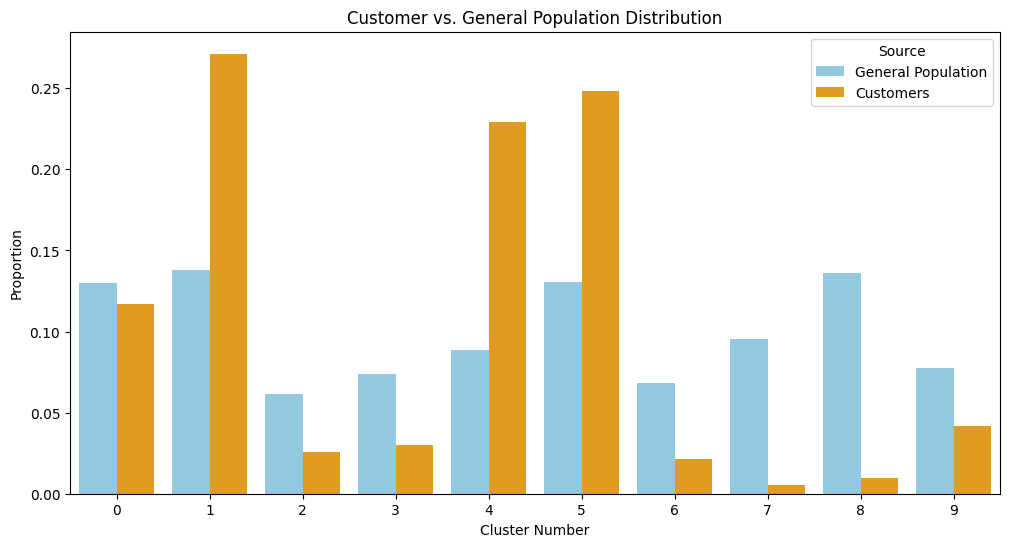

In [21]:
import seaborn as sns

# Compare General Population vs Customers
general_prop = azdias_low_missing['CLUSTER'].value_counts(normalize=True).sort_index()
customer_prop = customers_clean['CLUSTER'].value_counts(normalize=True).sort_index()

df_general = pd.DataFrame({'Cluster': general_prop.index, 'Proportion': general_prop.values, 'Source': 'General Population'})
df_customer = pd.DataFrame({'Cluster': customer_prop.index, 'Proportion': customer_prop.values, 'Source': 'Customers'})
df_compare = pd.concat([df_general, df_customer])

plt.figure(figsize=(12, 6))
sns.barplot(x='Cluster', y='Proportion', hue='Source', data=df_compare, palette=['skyblue', 'orange'])
plt.xlabel('Cluster Number')
plt.title('Customer vs. General Population Distribution')
plt.show()

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [22]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

print("Training Gradient Boosting Classifier (this takes 1-2 mins)...")

# Initialize the model
# We use a simple Gradient Boosting model which is very effective for this data
model = GradientBoostingClassifier(random_state=42)

# Train the model
model.fit(X_train_pca, y_train)

# Evaluate using ROC-AUC (The metric required for the Kaggle competition)
# A score of 0.5 is random guessing. Anything above 0.6 is decent for this difficult dataset.
train_probs = model.predict_proba(X_train_pca)[:, 1]
score = roc_auc_score(y_train, train_probs)

print(f"Training ROC-AUC Score: {score:.4f}")

Training Gradient Boosting Classifier (this takes 1-2 mins)...
Training ROC-AUC Score: 0.9105


In [23]:
# 1. Store the LNR column for the final submission
# The Test dataset does NOT have a 'RESPONSE' column, so we don't drop it.
test_lnr = mailout_test['LNR']
X_test = mailout_test.copy()

print(f"Test Data Shape: {X_test.shape}")

# 2. Clean the Test Data (Apply EXACTLY the same steps as Training)
# Drop bad columns
X_test_clean = X_test.drop(columns=columns_to_drop)

# Replace missing values
X_test_clean = X_test_clean.replace(missing_values_dict, np.nan)

# Fix Categorical Columns
X_test_clean['OST_WEST_KZ'] = X_test_clean['OST_WEST_KZ'].replace({'W': 0, 'O': 1})
X_test_clean = X_test_clean.drop(columns=cols_to_drop_cat)
for col in cols_to_numeric:
    X_test_clean[col] = pd.to_numeric(X_test_clean[col], errors='coerce')

# 3. Impute Missing Values
X_test_imputed = pd.DataFrame(imputer.transform(X_test_clean), columns=X_test_clean.columns)

# 4. Scale the Data
X_test_scaled = scaler.transform(X_test_imputed)

# 5. PCA Transformation
X_test_pca = pca.transform(X_test_scaled)

print("Test data processed! Ready for prediction.")
print(f"Final Test Shape: {X_test_pca.shape}")

Test Data Shape: (42833, 366)


/opt/venv/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


Test data processed! Ready for prediction.
Final Test Shape: (42833, 217)


In [24]:
# 1. Predict probabilities (we want the probability of "1", i.e., "Yes")
pred_probs = model.predict_proba(X_test_pca)[:, 1]

# 2. Create the submission DataFrame
submission = pd.DataFrame({
    'LNR': test_lnr,
    'RESPONSE': pred_probs
})

# 3. Save to CSV
submission.to_csv('submission.csv', index=False)

print("SUCCESS: 'submission.csv' has been created!")
print(submission.head())

SUCCESS: 'submission.csv' has been created!
    LNR  RESPONSE
0  1754  0.008894
1  1770  0.964515
2  1465  0.007544
3  1470  0.006896
4  1478  0.003674
